# Run with embeddings that use unobserved residues


In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATASET = 'cryptobench'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/apolo/data/embeddings/cryptobench-v2/cryptobench-ahojv2-cut'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load the dataset

In [5]:
is_in_p2rank = ['1arlA', '1bk2A', '1bzjA', '1cwqA', '1dq2A', '1e6kA', '1evyA', '1g59A', '1h13A', '1i7nA', '1k47D', '1ksgB', '1kx9A', '1kxrA', '1lbeB', '1m5wD', '1nd7A', '1p4oB', '1p4vA', '1p9oA', '1pu5C', '1q4kA', '1rjbA', '1rtcA', '1se8A', '1ukaA', '1uteA', '1vsnA', '1x2gC', '1xgdA', '1xjfA', '1xqvA', '1xtcA', '1zm0A', '2akaA', '2d05A', '2dfpA', '2femA', '2fhzB', '2h7sA', '2i3aD', '2i3rA', '2iytA', '2phzA', '2pkfA', '2pwzG', '2qbvA', '2rfjB', '2v6mD', '2vl2C', '2vqzF', '2vyrA', '2w8nA', '2x47A', '2xsaA', '2zj7A', '3a0xA', '3bjpA', '3f4kA', '3flgA', '3fzoA', '3gdgB', '3h8aB', '3i8sB', '3idhA', '3jzgA', '3k01A', '3ly8A', '3mwgB', '3n4uA', '3nx1B', '3pbfA', '3rwvA', '3st6C', '3t8bA', '3tpoA', '3ugkA', '3uyiA', '3v55A', '3vgmA', '3w90A', '3wb9C', '4aemA', '4amvB', '4bg8A', '4cmwB', '4dncB', '4e1yA', '4fkmB', '4gpiC', '4gv9A', '4hyeA', '4ikvA', '4ilgA', '4j4eF', '4jaxF', '4jfrC', '4kmyA', '4mwiA', '4nzvB', '4oqoB', '4p2fA', '4qvkB', '4r0xA', '4rvtB', '4ttpA', '4uc8A', '4uumA', '4zm7A', '4zoeB', '5acvB', '5b0eB', '5cazA', '5e0vA', '5ey7B', '5hijA', '5htoE', '5i3tE', '5ighA', '5kcgB', '5locA', '5o8bA', '5sc2A', '5tc0B', '5tviV', '5uxaA', '5wbmB', '5yhbA', '5yj2C', '5yqpA', '5ysbB', '5z18C', '5zj4D', '6a98C', '6btyB', '6cqeB', '6du4A', '6eqjA', '6f52A', '6fc2C', '6fgjB', '6g6yA', '6heiA', '6isuA', '6jq9B', '6kscA', '6n5jB', '6neiB', '6o4fH', '6tx0B', '6vleA', '6w10A', '7c48A', '7c63A', '7de1A', '7e5qB', '7f2mB', '7f4yB', '7kayA', '7nc8D', '7ndlB', '7nlxA', '7o1iA', '7qoqA', '7qzrD', '7v8kB', '7w19A', '7x0fA', '7x0gB', '7x0iB', '7xgfE', '7yjcA', '8aeqA', '8aqiB', '8b9pA', '8breB', '8h27A', '8i84B', '8iasB', '8j11X', '8onnE', '8u3nA', '8vxuB', '9atcA']

class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys, p2rank_evaluation=False):
        _Xs_list = []
        _Ys_list = []
        for key, _ in _Xs.items():
            if not key in is_in_p2rank and p2rank_evaluation:
                continue
            # print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for aa, residue_idx in [(residue.split('_')[1][:1], int(residue.split('_')[1][1:])) for residue in row[3].split(' ')]:
                # if len(Ys[id]) <= residue_idx:
                #     continue
                # assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

In [11]:
DECISION_THRESHOLD = 0.95
DROPOUT = 0.3
LAYER_WIDTH = 256
ESM2_DIM  = 2560
class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.layer_4 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.dropout3(self.relu(self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x))))))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, bce_loss=nn.functional.binary_cross_entropy_with_logits, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction
        self.bce_loss = bce_loss

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = self.bce_loss(inputs, targets)
        
        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)
        
        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=8 * class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            # test_pred = torch.round(torch.sigmoid(test_logits))
            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)


        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc

# Try to recreate the results on the P2Rank subset 
The experiment was run separately to be compared with P2Rank and for that only a subset of the whole dataset was used. Let's use it to recreate the experiment using pytorch and compare the results.

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Class weights:  tensor([0.5286, 9.2441], device='cuda:0')
Epoch: 0 | Loss: 1.79634, Accuracy: 94.26% | Test loss: 3.86845, AUC: 0.4880, MCC: 0.0000, F1: 0.9148, AUPRC: 0.0562, sum: 0.0
Epoch: 1 | Loss: 1.35649, Accuracy: 93.61% | Test loss: 1.72294, AUC: 0.8651, MCC: 0.3559, F1: 0.9331, AUPRC: 0.3395, sum: 2547.0
Epoch: 2 | Loss: 1.36479, Accuracy: 93.85% | Test loss: 1.69149, AUC: 0.8751, MCC: 0.3899, F1: 0.9362, AUPRC: 0.3823, sum: 2644.0
Epoch: 3 | Loss: 1.18691, Accuracy: 93.69% | Test loss: 1.72338, AUC: 0.8767, MCC: 0.3962, F1: 0.9358, AUPRC: 0.3930, sum: 2888.0
Epoch: 4 | Loss: 1.06687, Accuracy: 93.69% | Test loss: 1.90096, AUC: 0.8754, MCC: 0.3957, F1: 0.9357, AUPRC: 0.4005, sum: 2878.0
Epoch: 5 | Loss: 1.04971, Accuracy: 93.21% | Test loss: 2.23815, AUC: 0.8735, MCC: 0.3987, F1: 0.9335, AUPRC: 0.4060, sum: 3399.0
Epoch: 6 | Loss: 0.75810, Accuracy: 93.51% | Test loss: 2.84437, AU

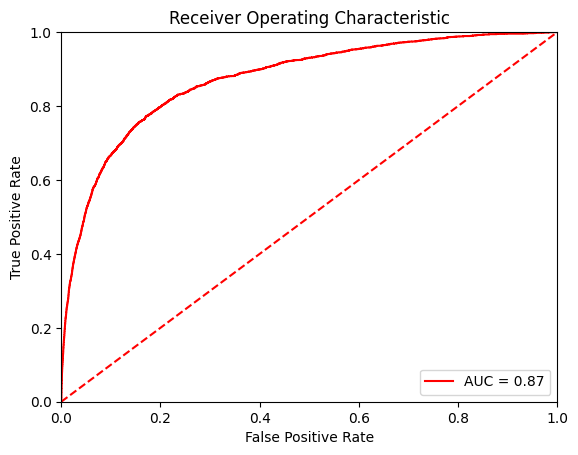

In [12]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/full-train.csv', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'/home/skrhakv/apolo/data/annotations/cryptobench-v2/cryptobench-translated-annotations/test.csv', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo, p2rank_evaluation=True)

model = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001, weight_decay=0.01)


_,_,_ = train(model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

In [ ]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/baseline-model-with-unobserved.pt'
torch.save(model, OUTPUT_PATH)
# Epoch: 6 | Loss: 0.75810, Accuracy: 93.51% | Test loss: 2.84437, AUC: 0.8732, MCC: 0.3988, F1: 0.9351, AUPRC: 0.4083, sum: 3096.0